# Data Science in Python
## Text Classification

Name: Karthikeyan Jawahar

# Choosing category to obtain review  and rating

Two categories are chosen, Restaurant and Hotel and Travel.
The review text and star ratings are stored into two separate csv files.
For analysis purposes the positive and negative rating categories are stored as '0' and '1'.
Note: Positive = '1' & Negative = '0'.

Import all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import requests
import re  
import nltk  
import io
import csv
import os.path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords  

Download wordnet for lemmatization

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/karthik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karthik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Task 1 : Data scraping and storing dataset

Function to scrape data from the web page(i.e.) scrape all restaurant data

In [3]:
import requests
from bs4 import BeautifulSoup

def get_data(url):                    #Finds the URL to required fdns file
    url_list = [] #to store all the restaurants url to scrape reviews
    page = requests.get(url)
    soup = BeautifulSoup(page.content,"html.parser")
    databuf = soup.findAll('h6') #inspect the site to check html elements, all restaurant names are stored in <h6> 
    for i in databuf:
        i = i.find('a')
        url_list.append(i.get('href')) #getting all restaurants individual page link
    return(url_list)


Storing all individual restaurant and hotel's webpage link for scraping

In [4]:
base_url = 'http://mlg.ucd.ie/modules/yalp/' #base url for the site
restaurant_list = get_data('http://mlg.ucd.ie/modules/yalp/restaurants_list.html') #all the individual url for restaurants stored as a list
hotel_travel_list = get_data('http://mlg.ucd.ie/modules/yalp/hotels_travel_list.html') #all the individual url for hotel and travel stored as a list


In [5]:
restaurant_reviews = []
hotel_travel_reviews = []

To scrape all the reviews from individual webpage and store it with review text and class label

In [6]:
def get_review_data(url):
    review_arr = []
    
    review_page = requests.get(url) #opening the individual restaurant
    rev_soup = BeautifulSoup(review_page.content,"html.parser")
    
    buffer = rev_soup.findAll('div',attrs={"class":"review"}) #finding reviews written inside div inspect any restaurant page to see the structure
    
    for i in buffer: #for all the divs that has reviews am getting the stars rating and review text by looping through all reviews
        contentObj = {}
        starCount = i.find('p',attrs={"class":"stars"}).find('img').get('alt').split("-")[0] #to get the number of stars
        if(int(starCount) <= 3):
            star=0#Negative rating(stars)
        else:
            star=1#Positive rating(stars)
        rev_tex = i.find('p',attrs={"class":"text"}).get_text() #to get review text
        contentObj["category"] = star #storing it in dict
        contentObj["review"] = rev_tex
        review_arr.append(contentObj) #appending the dict to a list to store all reviews as dict with ratings and text
         
    return review_arr
    

In [7]:
for urls in restaurant_list: #for all individual urls, looping it to get all the reviews from that page and store it in array
    main_url = base_url + urls 
    restaurant_reviews = restaurant_reviews + get_review_data(main_url) #storing all the list of restaurant reviews into single list
    
for urls in hotel_travel_list: #for all individual urls, looping it to get all the reviews from that page and store it in array
    main_url_hotel = base_url + urls 
    hotel_travel_reviews = hotel_travel_reviews + get_review_data(main_url_hotel) #storing all the list of hotel and travel reviews into single list
           
    

Check for the length to find if all the reviews are scraped properly

In [8]:
len(restaurant_reviews)

1440

In [9]:
len(hotel_travel_reviews)

1430

Store all the review and the class labels for each of the categories into two separate CSV files

In [10]:

csv_columns = ['review','category']

restaurant_csv_file = "Restaurants.csv"
hotel_csv_file = "Hotel_and_Travel.csv"

#for restaurant
try:
    with open(restaurant_csv_file, 'w', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in restaurant_reviews:
            writer.writerow(data)
except IOError:
    print("I/O error") 

#for hotel and travel
try:
    with open(hotel_csv_file, 'w', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in hotel_travel_reviews:
            writer.writerow(data)
except IOError:
    print("I/O error") 

Loading CSV file into dataframe

In [11]:
restaurant_review_df = pd.read_csv('Restaurants.csv')
hotel_review_df = pd.read_csv("Hotel_and_Travel.csv")

# Task 2a : Text pre-processing

Display the dataframes

In [12]:
restaurant_review_df.head()

,review,category
0,Too expensive for what they had... i had an eg...,0
1,"Very rustic place. Mismatched furniture, off K...",1
2,I highly recommend Au Festin de Babette for th...,1
3,Amazing soup and dauphinoise. BUT the wait for...,0
4,I went here by recommendation of a friend. Tho...,0


In [13]:
hotel_review_df.head()

,review,category
0,I have used this service before and was satisf...,0
1,First time I tried using them the driver was n...,0
2,Driver picked me up on time at 6AM and even kn...,1
3,First time using this taxi and limo company as...,1
4,Great experience. Driver was early and was ver...,1


To check if the rating ratio is not biased

In [14]:
pd.crosstab(index = restaurant_review_df['category'], columns="Total count")


col_0,Total count
category,
0,507
1,933


In [15]:
pd.crosstab(index = hotel_review_df['category'], columns="Total count")


col_0,Total count
category,
0,637
1,793


As per pre-processing steps, removed all the special characters, multiple white spaces,converted text into tokens and applied stemmer and lemmatizer to normalize the review text 

In [16]:
def remove_extras(review):
    
    from nltk.stem.porter import PorterStemmer
    from nltk.stem import WordNetLemmatizer
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    documents = []
    for rev in range(0, len(review)):
        
        #Remove Special Character
        document = re.sub(r'\W', ' ', str(review[rev]))
        
        #Remove multiple white spaces
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        
        document = document.split()
        
        for i in range(0,len(document)):
            document[i] = stemmer.stem(document[i])
        
        document = ' '.join(document)
        
        document = document.split()
        
        for i in range(0,len(document)):
            document[i] = lemmatizer.lemmatize(document[i])
        
        document = ' '.join(document)
        
        documents.append(document)
        
        
    return documents

In [17]:
#a call to remove extras
restaurant_review_df['review'] = remove_extras(restaurant_review_df['review'])
hotel_review_df['review'] = remove_extras(hotel_review_df['review'])

In [18]:
#sample display
restaurant_review_df['review'][0]


'too expens for what they had i had an egg benedict plate call la drolet but it had a weird side soup with a desert that I dont person like I dont think i will go back there again'

In [19]:
#sample display
hotel_review_df['review'][0]

'I have use thi servic befor and wa satisfi until june 20 2018 I prearrang via telephon a pickup from termin 3 to georgetown and clearli specifi a credit card would be use for payment to the driver the car 570l arriv quickli and wa clean and the drive unev when it came time to pay I present my mastercard and that s when the problem start the driver found he had no connect on hi payment devic He tri sever time to put the card throug he even tri to put hi own card through at one paint in thi debacl and each time the unit said no connect He then tri drive the car with me in it off my properti and up and down the street in search of an internet connect at one point he drove me to an auto repair facil up the road stop along the way and stay park in the auto park lot tri to obtain internet servic I final ask after a veri extend period to plea return to my properti to sort it out It wa get dark and I wa travel alon and get anxiou I onli had a credit card in which to pay with He proceed to sug

Converting Text to numbers

Step 1 : Splitting the data into test and train to apply vectorization and TFIDF

In [20]:
from sklearn.model_selection import train_test_split
# Split data into training and test sets
R_train, R_test, Ry_train, Ry_test = train_test_split(restaurant_review_df['review'], restaurant_review_df['category'], random_state=0, test_size=0.2)
H_train, H_test, Hy_train, Hy_test = train_test_split(hotel_review_df['review'], hotel_review_df['category'], random_state=0, test_size=0.2)
# , stratify= review_df['category'], test_size=0.2


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  

Vectorization using N-Grams and TFIDF (With stop words removal) in training data for both categories 

In [22]:
Restaurant_vectorizer = CountVectorizer(ngram_range = (1,2), stop_words="english", min_df = 30)
X_Restaurant_train = Restaurant_vectorizer.fit_transform(R_train)

In [23]:
Hotel_vectorizer = CountVectorizer(ngram_range = (1,2), stop_words="english", min_df = 30)
X_Hotel_train = Hotel_vectorizer.fit_transform(H_train)

In [24]:
Res_tfidfconverter = TfidfTransformer()  
X_Restaurant_train = Res_tfidfconverter.fit_transform(X_Restaurant_train) 

In [25]:
Hotel_tfidfconverter = TfidfTransformer()  
X_Hotel_train = Hotel_tfidfconverter.fit_transform(X_Hotel_train) 

In [26]:
#sparse matrix
X_Restaurant_train

<1152x405 sparse matrix of type '<class 'numpy.float64'>'
	with 32427 stored elements in Compressed Sparse Row format>

In [27]:
#sparse matrix
X_Hotel_train

<1144x492 sparse matrix of type '<class 'numpy.float64'>'
	with 39143 stored elements in Compressed Sparse Row format>

Vectorization and TFIDF in test data for both categories
As the training data is already fitted with vectorizer, the test data is only transformed

In [28]:
X_Restaurant_test = Restaurant_vectorizer.transform(R_test)

In [29]:
X_Hotel_test = Hotel_vectorizer.transform(H_test)

In [30]:
X_Restaurant_test = Res_tfidfconverter.transform(X_Restaurant_test) 

In [31]:
X_Hotel_test = Hotel_tfidfconverter.transform(X_Hotel_test) 

In [32]:
X_Restaurant_test

<288x405 sparse matrix of type '<class 'numpy.float64'>'
	with 8228 stored elements in Compressed Sparse Row format>

In [33]:
X_Hotel_test

<286x492 sparse matrix of type '<class 'numpy.float64'>'
	with 9463 stored elements in Compressed Sparse Row format>

# Task 2b : Building classification models 

Cross validation of various classification models

In [34]:
#Importing required packages
# from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier


Function to perform cross validation

In [35]:
from sklearn.model_selection import cross_val_score

def cross_validation(features,labels,data_name):
    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(random_state=0),
        KNeighborsClassifier(n_neighbors=3)
    ]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=["model_name", 'fold_idx', 'accuracy'])
        import seaborn as sns
        sns.boxplot(x='model_name', y='accuracy', data=cv_df)
        sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                      size=12, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    print(cv_df.groupby('model_name').accuracy.mean())

Box plot to understand the average accuracy value for all the classifier models based on train and test data

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


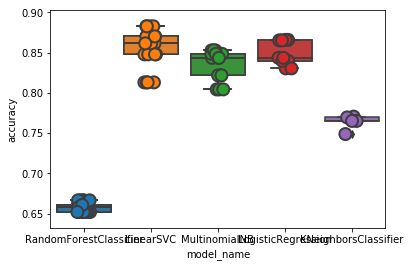

model_name
KNeighborsClassifier      0.763896
LinearSVC                 0.855016
LogisticRegression        0.848952
MultinomialNB             0.834173
RandomForestClassifier    0.657979
Name: accuracy, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


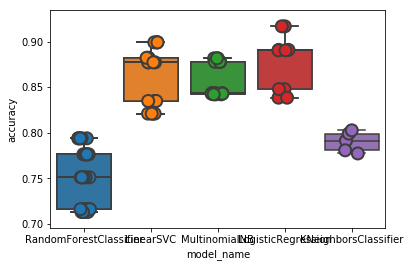

model_name
KNeighborsClassifier      0.790211
LinearSVC                 0.862831
LogisticRegression        0.876820
MultinomialNB             0.857537
RandomForestClassifier    0.750094
Name: accuracy, dtype: float64


In [36]:
cross_validation(X_Restaurant_train,Ry_train,"Restaurant")
cross_validation(X_Hotel_train,Hy_train,"Hotel And Travel")

From the above graphs it can be found that,
Fig 1& Fig 2: Linear SVC, Logistic regression and Multinomial NB performs decently when compared to K-NN and Random forest models (More outliers).
This is just a cross validation step, further below each classifier model will be checked individually to get the exact accuracy for each classifer.

In [37]:
#for accuracy plotting
auc_arr = []

In [38]:
# to print the accuraty, Confusion matrix, ROC and Classification Report for all classifiers and plotting ROC curve
def print_prediction_output(y_test, prediction_val):
    print('ROC_AUC: ', roc_auc_score(y_test, prediction_val))
    print('Confusion Matrix')
    print(confusion_matrix(y_test,prediction_val))  
    print('Classification Report')
    print(classification_report(y_test,prediction_val)) 
    accuracy = accuracy_score(y_test, prediction_val)
    auc_arr.append(accuracy)
    print('Accuracy Score',accuracy)  
    fpr, tpr, thresholds = roc_curve(y_test, prediction_val)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1.1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1.1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


# Building Calssifiers

Naive Bayes Classifier

In [39]:
def Naive_Bayes_classifier(X_train, y_train, X_test, y_test):
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    NB_predictions = clf.predict(X_test)
    print_prediction_output(y_test, NB_predictions)

Logistic Regression Classifier

In [40]:
def Logistic_Reg_classifier(X_train, y_train, X_test, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print_prediction_output(y_test, predictions) 

Random Forest Classifier

In [41]:
def Random_forest_classifier(X_train, y_train, X_test, y_test):
    regressor = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)  
    regressor.fit(X_train, y_train)  
    RF_prediction = regressor.predict(X_test)  
    print_prediction_output(y_test, RF_prediction.round())

SVM - Linear SVC Classifier

In [42]:
def SVC_classifier(X_train, y_train, X_test, y_test):
    model = LinearSVC()
    model.fit(X_train, y_train)
    SVM_prediction = model.predict(X_test)
    print_prediction_output(y_test, SVM_prediction)

K-Nearest neighbour Classifier

In [43]:
def KNN(X_train, y_train, X_test, y_test):
    model = KNeighborsClassifier(n_neighbors=3) #3 - Neighbours
    # Train the model using the training sets
    model.fit(X_train, y_train)
    #Predict Output
    KNN_predicted= model.predict(X_test) # 0:Overcast, 2:Mild
    print_prediction_output(y_test, KNN_predicted)

# Task 2c : Testing and discussing prediction results for each category with all classifiers

Prediction for Restaurant data

ROC curve is plotted for true positive rates vs false positive rates

ROC_AUC:  0.7861579414374446
Confusion Matrix
[[ 55  37]
 [  5 191]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.60      0.72        92
           1       0.84      0.97      0.90       196

   micro avg       0.85      0.85      0.85       288
   macro avg       0.88      0.79      0.81       288
weighted avg       0.86      0.85      0.84       288

Accuracy Score 0.8541666666666666


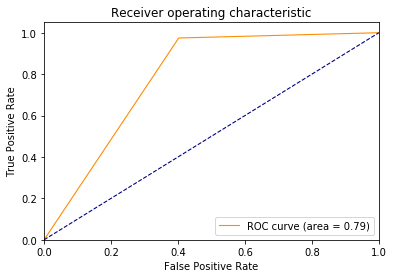

In [44]:
Naive_Bayes_classifier(X_Restaurant_train, Ry_train, X_Restaurant_test, Ry_test)

Accuracy rate is 85 %, still confusion matrix shows that data is slightly biased towards Positive ratings ( more value for predicted Yes(positive) while it is actually an Actual No(negative) value)

ROC_AUC:  0.803793256433008
Confusion Matrix
[[ 62  30]
 [ 13 183]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        92
           1       0.86      0.93      0.89       196

   micro avg       0.85      0.85      0.85       288
   macro avg       0.84      0.80      0.82       288
weighted avg       0.85      0.85      0.85       288

Accuracy Score 0.8506944444444444


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


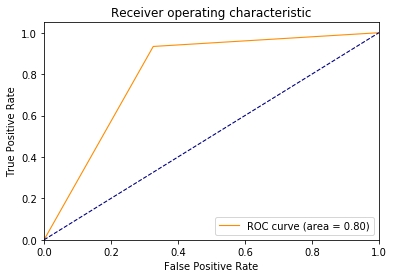

In [45]:
Logistic_Reg_classifier(X_Restaurant_train, Ry_train, X_Restaurant_test, Ry_test)

Accuracy rate is 85 %, still confusion matrix shows that data is slightly biased towards Positive ratings but lesser when compared to Naive Bayes. Higher recall for positive supports that it is biased towards positive.

ROC_AUC:  0.5409272404614021
Confusion Matrix
[[  8  84]
 [  1 195]]
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.09      0.16        92
           1       0.70      0.99      0.82       196

   micro avg       0.70      0.70      0.70       288
   macro avg       0.79      0.54      0.49       288
weighted avg       0.76      0.70      0.61       288

Accuracy Score 0.7048611111111112


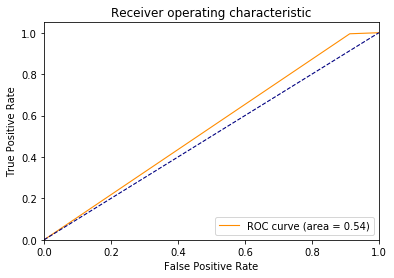

In [46]:
Random_forest_classifier(X_Restaurant_train, Ry_train, X_Restaurant_test, Ry_test)

Accuracy rate is 70% which is low compared to others and confusion matrix shows that data is highly biased towards Positive ratings. The recall and f1-score from the classification report shows that higher values for positive ratings and much lower values for negative ratings.

ROC_AUC:  0.8153283052351377
Confusion Matrix
[[ 66  26]
 [ 17 179]]
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.72      0.75        92
           1       0.87      0.91      0.89       196

   micro avg       0.85      0.85      0.85       288
   macro avg       0.83      0.82      0.82       288
weighted avg       0.85      0.85      0.85       288

Accuracy Score 0.8506944444444444


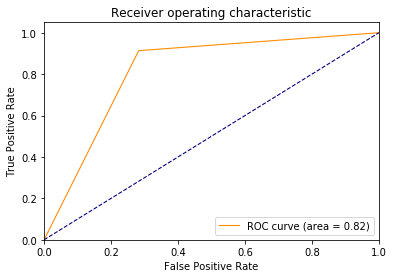

In [47]:
SVC_classifier(X_Restaurant_train, Ry_train, X_Restaurant_test, Ry_test)

Accuracy rate is 85 % and confusion matrix shows that data is not biased when compared to other classifiers. Recall precision and f1 scores are evenly distributed for positive and negative.

ROC_AUC:  0.7412377994676131
Confusion Matrix
[[ 58  34]
 [ 29 167]]
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        92
           1       0.83      0.85      0.84       196

   micro avg       0.78      0.78      0.78       288
   macro avg       0.75      0.74      0.74       288
weighted avg       0.78      0.78      0.78       288

Accuracy Score 0.78125


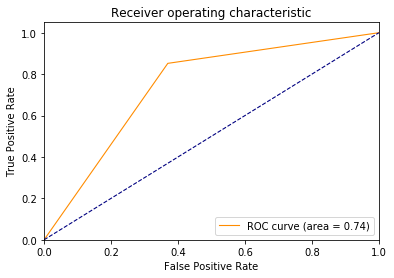

In [48]:
KNN(X_Restaurant_train, Ry_train, X_Restaurant_test, Ry_test)

Accuracy rate is 78 % and confusion matrix shows that its not much biased.

Plot graph to show different acuuracy values for classifiers

In [49]:
auc_arr

[0.8541666666666666,
 0.8506944444444444,
 0.7048611111111112,
 0.8506944444444444,
 0.78125]

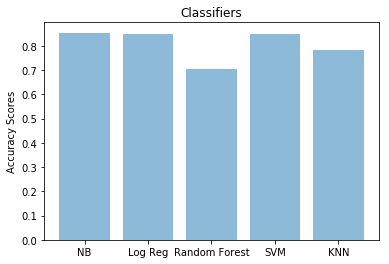

<Figure size 1440x720 with 0 Axes>

In [50]:
objects = ('NB', 'Log Reg', 'Random Forest', 'SVM', 'KNN')
y_pos = np.arange(len(objects))
performance = auc_arr

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy Scores')
plt.title('Classifiers')
plt.figure(figsize=(20,10))
plt.show()

From the acuracy values obtained, ROC curve, confusion matrix , precision recall scores it can be seen that Logistic regression and SVM classifiers perform with high accuracy and are less biased. K-NN has lesser accuracy compared to logistic and SVM but it is more unbiased.

Prediction for Hotel and Travel Data

::::: Hotel and Travel :::::
ROC_AUC:  0.8258509389671361
Confusion Matrix
[[105  39]
 [ 11 131]]
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       144
           1       0.77      0.92      0.84       142

   micro avg       0.83      0.83      0.83       286
   macro avg       0.84      0.83      0.82       286
weighted avg       0.84      0.83      0.82       286

Accuracy Score 0.8251748251748252


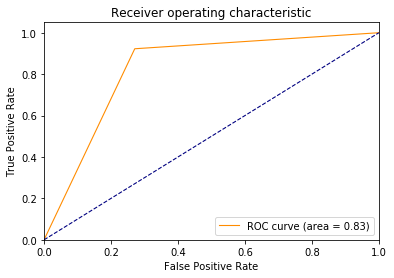

In [51]:
#Hotel and Travel
auc_arr = []
print("::::: Hotel and Travel :::::")
Naive_Bayes_classifier(X_Hotel_train, Hy_train, X_Hotel_test, Hy_test)

Accuracy rate is 82 %, still confusion matrix shows that data is slightly biased towards Positive ratings ( more value for predicted Yes(positive) while it is actually an Actual No(negative) value)

ROC_AUC:  0.8259487480438183
Confusion Matrix
[[103  41]
 [  9 133]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.72      0.80       144
           1       0.76      0.94      0.84       142

   micro avg       0.83      0.83      0.83       286
   macro avg       0.84      0.83      0.82       286
weighted avg       0.84      0.83      0.82       286

Accuracy Score 0.8251748251748252


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


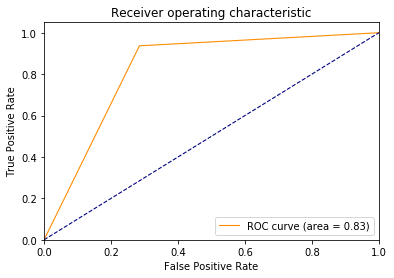

In [52]:
Logistic_Reg_classifier(X_Hotel_train, Hy_train, X_Hotel_test, Hy_test)

Accuracy rate is 82 %, still confusion matrix shows that data is slightly biased towards Positive ratings but higher when compared to Naive Bayes. Higher recall for positive supports that it is biased towards positive.

ROC_AUC:  0.690923317683881
Confusion Matrix
[[ 56  88]
 [  1 141]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.39      0.56       144
           1       0.62      0.99      0.76       142

   micro avg       0.69      0.69      0.69       286
   macro avg       0.80      0.69      0.66       286
weighted avg       0.80      0.69      0.66       286

Accuracy Score 0.6888111888111889


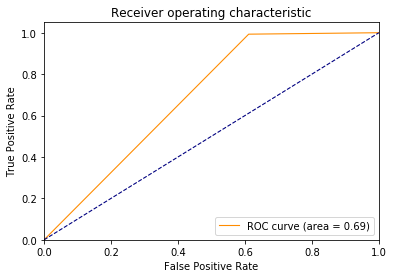

In [53]:
Random_forest_classifier(X_Hotel_train, Hy_train, X_Hotel_test, Hy_test)

Accuracy rate is 69% which is low compared to others and confusion matrix shows that data is highly biased towards Positive ratings. The recall and f1-score from the classification report shows that higher values for positive ratings and much lower values for negative ratings.

ROC_AUC:  0.839739827856025
Confusion Matrix
[[109  35]
 [ 11 131]]
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       144
           1       0.79      0.92      0.85       142

   micro avg       0.84      0.84      0.84       286
   macro avg       0.85      0.84      0.84       286
weighted avg       0.85      0.84      0.84       286

Accuracy Score 0.8391608391608392


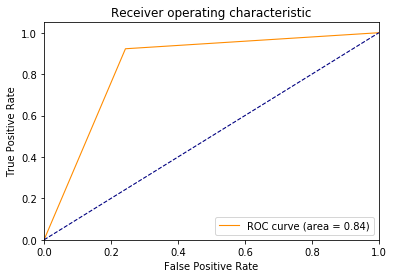

In [54]:
SVC_classifier(X_Hotel_train, Hy_train, X_Hotel_test, Hy_test)

Accuracy rate is 83 % and confusion matrix shows that data is less biased when compared to other classifiers. Recall precision and f1 scores are distributed with small differences.

ROC_AUC:  0.7416862284820032
Confusion Matrix
[[ 98  46]
 [ 28 114]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       144
           1       0.71      0.80      0.75       142

   micro avg       0.74      0.74      0.74       286
   macro avg       0.75      0.74      0.74       286
weighted avg       0.75      0.74      0.74       286

Accuracy Score 0.7412587412587412


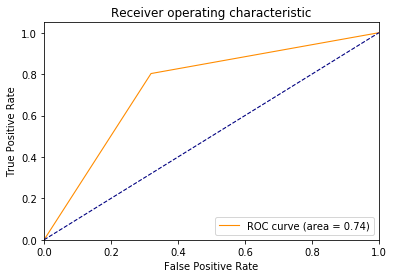

In [55]:
KNN(X_Hotel_train, Hy_train, X_Hotel_test, Hy_test)

Accuracy rate is 74 % and confusion matrix shows that its not much biased.

In [56]:
auc_arr

[0.8251748251748252,
 0.8251748251748252,
 0.6888111888111889,
 0.8391608391608392,
 0.7412587412587412]

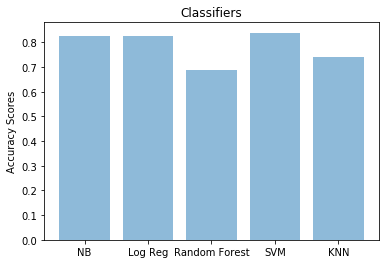

<Figure size 1440x720 with 0 Axes>

In [57]:
objects = ('NB', 'Log Reg', 'Random Forest', 'SVM', 'KNN')
y_pos = np.arange(len(objects))
performance = auc_arr

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy Scores')
plt.title('Classifiers')
plt.figure(figsize=(20,10))
plt.show()

From the acuracy values obtained, ROC curve, confusion matrix , precision recall scores it can be seen that Logistic regression and SVM classifiers perform with high accuracy and are less biased. K-NN has lesser accuracy compared to logistic and SVM but it is more unbiased. Eventhough naive bayes is less biased than logistic regression, for high accuracy percentage we consider Logistic regression to be better.

# TASK 3 : Evaluation of classification models transfer between categories

Joined two categories dataframes to avoid inconsistent structure while vectorizing the text
Note: the dataframes are already normalized with text pre-processing steps

In [58]:
reviews_df = pd.concat([restaurant_review_df,hotel_review_df])

In [59]:
reviews_df.head()

,review,category
0,too expens for what they had i had an egg bene...,0
1,veri rustic place mismatch furnitur off knick ...,1
2,I highli recommend Au festin de babett for the...,1
3,amaz soup and dauphinois but the wait for the ...,0
4,I went here by recommend of a friend though th...,0


In [60]:
len(reviews_df)

2870

Performing text to number conversion using countvectorizer in the combined dataset.
TFIDF not perfromed since it would not be suitable for the whole dataset.

In [61]:
Review_vectorizer = CountVectorizer(ngram_range = (1,2), stop_words="english", min_df = 30)
Main_Review_train = Review_vectorizer.fit_transform(reviews_df['review'])

In [62]:
Main_Review_train

<2870x1033 sparse matrix of type '<class 'numpy.int64'>'
	with 111534 stored elements in Compressed Sparse Row format>

Split dataset into category A & B(restaurant and hotel)

Category A

In [63]:
M_R_train, M_R_test, My_R_train, My_R_test = train_test_split(Main_Review_train[:1400], reviews_df['category'][:1400], random_state=0, test_size=0.2)


Category B

In [64]:
M_H_train, M_H_test, My_H_train, My_H_test = train_test_split(Main_Review_train[1441:2801], reviews_df['category'][1441:2801], random_state=0, test_size=0.2)


## Hypothesis:
### 1. Model Trained on Restaurant will perform similarly or better when tested with Hotel and Travel
### 2. Model Trained on Hotel and Travel will perform similarly or better when tested with Restaurant

# Task 3a : Train a classification model on the data from “Category A”, and evaluate its performance on the data from “Category B”.


From the task 2 results, we have considered two classifiers.
SVM - Linear SVC & Logistic regression

Logistic regression perfomed, trained with category A and tested with category B

ROC_AUC:  0.8197664947054032
Confusion Matrix
[[111  16]
 [ 34 111]]
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       127
           1       0.87      0.77      0.82       145

   micro avg       0.82      0.82      0.82       272
   macro avg       0.82      0.82      0.82       272
weighted avg       0.82      0.82      0.82       272

Accuracy Score 0.8161764705882353


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


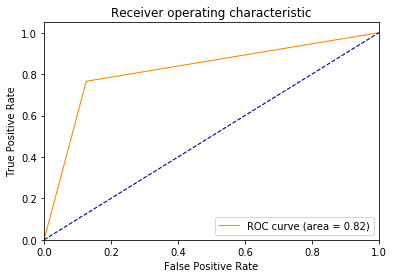

In [65]:
Logistic_Reg_classifier(M_R_train, My_R_train, M_H_test, My_H_test)

Linear SVC perfomed, trained with category A and tested with category B

ROC_AUC:  0.7867770838989956
Confusion Matrix
[[107  20]
 [ 39 106]]
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       127
           1       0.84      0.73      0.78       145

   micro avg       0.78      0.78      0.78       272
   macro avg       0.79      0.79      0.78       272
weighted avg       0.79      0.78      0.78       272

Accuracy Score 0.7830882352941176


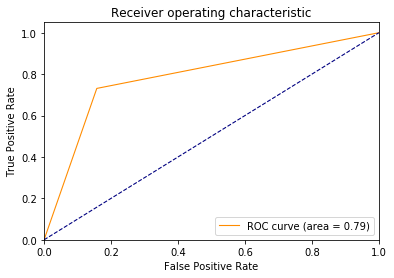

In [66]:
SVC_classifier(M_R_train, My_R_train, M_H_test, My_H_test)

# Task 3b : Train a classification model on the data from “Category B”, and evaluate its performance on the data from “Category A”.

Logistic regression perfomed, trained with category B and tested with category A

ROC_AUC:  0.8037563339942718
Confusion Matrix
[[ 74  28]
 [ 21 157]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       102
           1       0.85      0.88      0.87       178

   micro avg       0.82      0.82      0.82       280
   macro avg       0.81      0.80      0.81       280
weighted avg       0.82      0.82      0.82       280

Accuracy Score 0.825


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


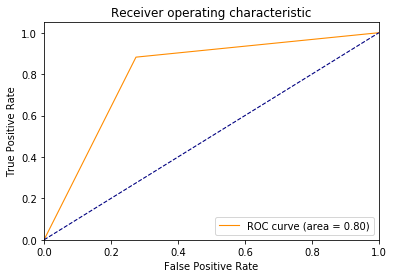

In [67]:
Logistic_Reg_classifier(M_H_train, My_H_train, M_R_test, My_R_test)

Linear SVC perfomed, trained with category B and tested with category A

ROC_AUC:  0.7791914518616436
Confusion Matrix
[[ 73  29]
 [ 28 150]]
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       102
           1       0.84      0.84      0.84       178

   micro avg       0.80      0.80      0.80       280
   macro avg       0.78      0.78      0.78       280
weighted avg       0.80      0.80      0.80       280

Accuracy Score 0.7964285714285714


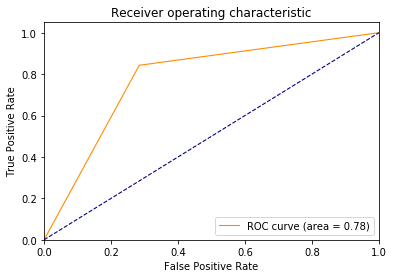

In [68]:
SVC_classifier(M_H_train, My_H_train, M_R_test, My_R_test)

## Result:
### Evaluation of Hypothesis:

#### Hypothesis 1: 

From the evaluation of task 3a it is clear that accuracy is reduced and bias is shifted towards negative reviews as well for both the classifiers.

###### 1.The model trained on Restaurant reviews has 85% accuracy when tested on Restaurant reviews whereas 82% and 78% accuracy when tested on Hotel and Travel reviews with a shift in bias towards negative review for both classifiers.

##### Thus the Null hypothesis is accepted. 
#### Null Hypothesis: Model Trained on Restaurant will not perform similarly or better when tested with Hotel and Travel

The case of Null hypothesis being accepted for both classifiers would be because of the shift of bias towards negative rating when tested with different data. This can be caused because of difference in sparse matrix and similarity between the reviews. The Restauarant and Hotels can have similar nature of reviews but yet differ in the terms used and the length of reviews are comparatively smaller would result in smaller sparse matrix.

#### Hypothesis 2: 
From the evaluation of task 3b it is clear that accuracy is similar for Logistic Regression and reduced for Linear SVC but the bias is reduced it became modest for both the classifiers makes the performance better compared with the actual performance.

###### 1.The model trained on Hotel and Travel reviews has 82% and 83%  accuracy when tested on Hotel and Travel reviews whereas 82% and 80% accuracy when tested on Hotel and Travel reviews with a better modest bias.

##### Thus the hypothesis is accepted for Logistic Regression and  Linear SVC. 
#### Hypothesis: Model Trained on Hotel and Travel will perform similarly or better when tested with Restaurant


The case of Hypothesis being accepted would be because the accuracy rate is maintained similarly and even the bias between positve and negative rating which was there in task 2 is reduced and made modest when tested with transfered categories. This improves the accuracy and performance of the classifiers. The length of hotel and travel reviews were comparatively longer which would of created a better sparse matrix for the model training.